<a href="https://colab.research.google.com/github/YugantGotmare/Transfer-Learning-for-Endoscopic-Image-Analysis-with-kvasir-data/blob/main/kvasir_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [22]:
!kaggle datasets download -d meetnagadia/kvasir-dataset

kvasir-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [23]:
import zipfile
zip_ref = zipfile.ZipFile('/content/kvasir-dataset.zip')
zip_ref.extractall('/content/Data')
zip_ref.close()

In [24]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dropout,Dense,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [25]:
path = '/content/Data/kvasir-dataset'

In [26]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    # shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

test_data= tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 4000 files belonging to 8 classes.
Using 3200 files for training.
Found 4000 files belonging to 8 classes.
Using 800 files for validation.


In [27]:
class_names = train_data.class_names
class_names

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

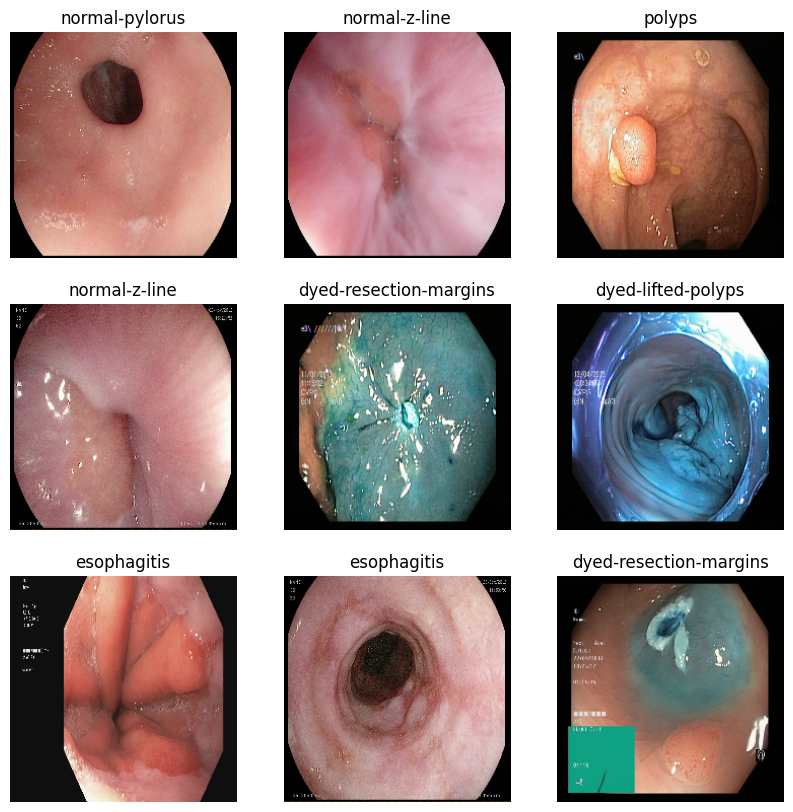

In [28]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i+1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(class_names[labels[i]])
      plt.axis('off')

In [29]:
base_model = keras.applications.MobileNetV3Small(input_shape=(224,224,3),
classes=400,
include_top=False,
weights='imagenet')

In [30]:
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [31]:
data_augmentation = keras.models.Sequential([
keras.layers.RandomFlip('horizontal'),
keras.layers.RandomRotation(0.2)
])

In [47]:
num_classes = len(class_names)

inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [48]:
model.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 576)               0         
                                                                 
 dense_4 (Dense)             (None, 8)                 4616      
                                                                 
Total params: 943,736
Trainable params: 4,616
Non-trainable

In [49]:
initial_epochs = 10

early = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=1, verbose=1, mode='auto')

check = ModelCheckpoint(monitor='val_accuracy',filepath="./bestmodel.h5", save_best_only=True, verbose=1, mode='auto')

call = [early,check]

In [50]:
history = model.fit(train_data,
validation_data=test_data,
epochs=initial_epochs,
callbacks=call)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 1.4123 - accuracy: 0.4922
Epoch 1: val_accuracy improved from -inf to 0.75875, saving model to ./bestmodel.h5
100/100 [==============================] - 36s 301ms/step - loss: 1.4123 - accuracy: 0.4922 - val_loss: 0.7231 - val_accuracy: 0.7588
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.7559
Epoch 2: val_accuracy improved from 0.75875 to 0.83625, saving model to ./bestmodel.h5
100/100 [==============================] - 37s 354ms/step - loss: 0.6903 - accuracy: 0.7559 - val_loss: 0.5129 - val_accuracy: 0.8363
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.5384 - accuracy: 0.8094
Epoch 3: val_accuracy improved from 0.83625 to 0.86375, saving model to ./bestmodel.h5
100/100 [==============================] - 31s 294ms/step - loss: 0.5384 - accuracy: 0.8094 - val_loss: 0.4354 - val_accuracy: 0.8637
Epoch 4/10
100/100 [==============================] 

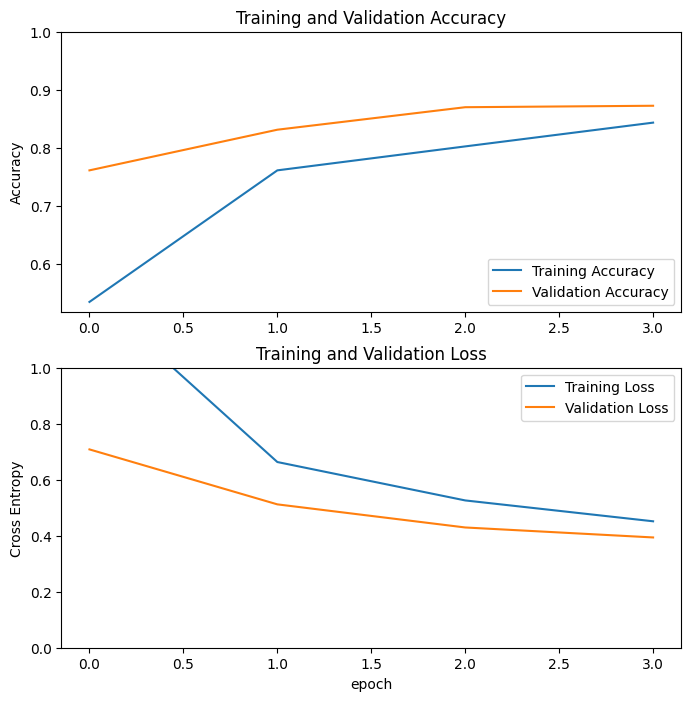

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
test_loss, test_acc = model.evaluate(test_data)
print('test accuracy : ', test_acc)

25/25 [==============================] - 7s 215ms/step - loss: 0.3938 - accuracy: 0.8725
test accuracy :  0.8725000023841858


In [38]:
results = model.evaluate(test_data, verbose=0)

In [39]:
print("Test Loss: {:.5f}".format(results[0]))
print("Accuracy on the test set: {:.2f}%".format(results[1] * 100))

Test Loss: 0.39384
Accuracy on the test set: 87.25%


1/1 [==============================] - 1s 1s/step


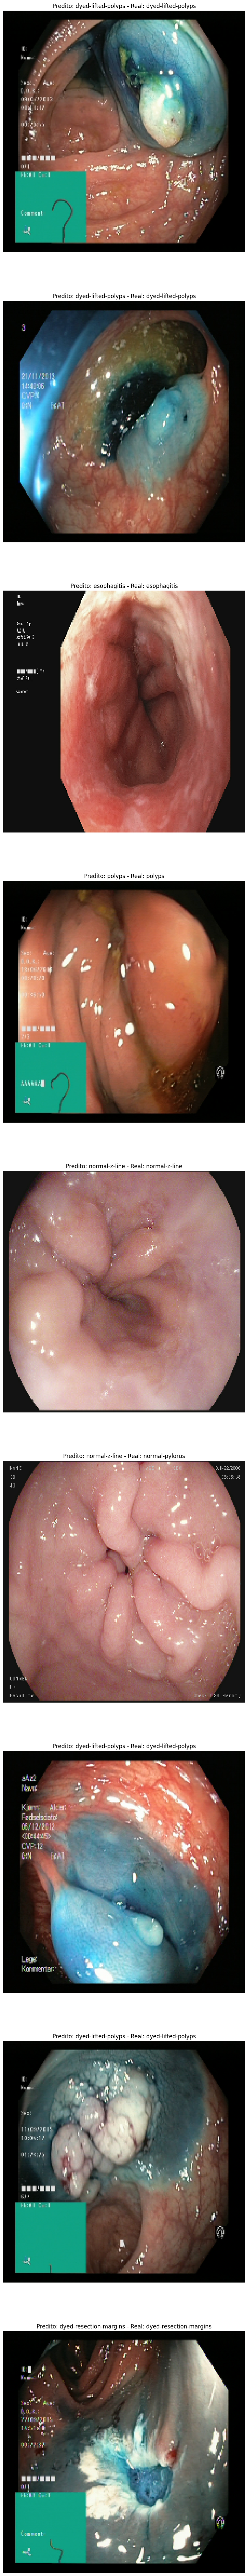

In [40]:
plt.figure(figsize=(10, 100))
for images, labels in test_data.take(1):
  prediction = model.predict(images,batch_size=32)
  for i in range(9):
    ax = plt.subplot(9, 1, i+1)
    pred = np.argmax(prediction[i])
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(f'Predito: {class_names[pred]} - Real: {class_names[labels[i].numpy()]}')
    plt.axis('off')
#Visualize